# Does OLR prediction have better properties?

In [179]:
import xarray as xr

import matplotlib.pyplot as plt

from src import utils, stats, ar_model

import dask

dask.config.set(**{"array.slicing.split_large_chunks": False})

In [180]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data4/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [181]:
DATA_DIR = "../../data/processed/"

In [224]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["axes.grid"] = True

## Cluster

In [4]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=16, processes=2, memory="47GB")
client = Client(cluster)
cluster.scale(jobs=2)

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Load some data to fit and compare to

#### Reanalysis data

In [105]:
tos = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = utils.calculate_period_AMV_index(tos["sst"], [12, 1, 2, 3]).to_dataset(name="AMV")
AMV = utils.round_to_start_of_month(AMV, dim="time")

psl = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = utils.calculate_period_NAO_index(psl["slp"], [12, 1, 2, 3]).to_dataset(name="NAO")

reanalysis = xr.merge((AMV.compute(), NAO.compute()), join="inner")
reanalysis = reanalysis.assign_coords({"time": reanalysis.time.dt.year})

#### Multi-model CMIP6 dcpp data

In [6]:
models = [
    "CanESM5",
    "CESM1-1-CAM5-CMIP5",
    "EC-Earth3",
    "HadGEM3-GC31-MM",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "NorCPM1",
]

n_init = 58

hindcast = []
prev_member = 0
for model in models:
    tos = xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_dcpp.zarr", use_cftime=True)
    AMV = utils.calculate_period_AMV_index(tos["tos"], [12, 1, 2, 3]).to_dataset(
        name="AMV"
    )
    AMV = AMV.assign_coords({"init": range(1960, 1960 + AMV.sizes["init"])})

    psl = xr.open_zarr(f"{DATA_DIR}/psl_Amon_{model}_dcpp.zarr", use_cftime=True) / 100
    NAO = utils.calculate_period_NAO_index(psl["psl"], [12, 1, 2, 3]).to_dataset(
        name="NAO"
    )

    NAO = NAO.assign_coords({"init": range(1960, 1960 + AMV.sizes["init"])})
    NAO = NAO.assign_coords({"init": range(1960, 1960 + AMV.sizes["init"])})

    ds = xr.merge((AMV.compute(), NAO.compute()))
    ds = ds.sel(lead=slice(14, 120)).assign_coords({"lead": range(1, 10)})
    ds = ds.assign_coords({"member": ds.member + prev_member})
    ds = ds.assign_coords({"model": ("member", ds.sizes["member"] * [model])})
    ds = utils.round_to_start_of_month(ds, "time")

    prev_member = ds.member.values[-1]

    hindcast.append(ds)

hindcast = xr.concat(
    hindcast, dim="member", coords="minimal", compat="override", join="inner"
)

hindcast_mean = utils.get_hindcast_mean(
    hindcast, mean_lead_range=[(0, 1), (0, 4), (0, 8)]
)

## Fit OLR to reanalysis data

In [202]:
leads = range(1, 10)
n_steps = len(leads)

input_data = reanalysis["AMV"]

input_data_stacked = []
for lead in leads:
    input_data_stacked.append(input_data.shift(time=-lead).assign_coords({"lead": lead}))
input_data_stacked = xr.concat(input_data_stacked, dim="lead")
input_data_stacked = input_data_stacked.assign_coords({"init_values": input_data})
input_data_stacked = input_data_stacked.rename({"time": "init"}).swap_dims({"init": "init_values"})

coeffs = input_data_stacked.polyfit(dim="init_values", deg=1)["polyfit_coefficients"]
coeffs = coeffs - coeffs.sel(degree=0)

olr_prediction = xr.polyval(input_data_stacked.init_values, coeffs)
olr_prediction = olr_prediction.assign_coords({"init": input_data_stacked.init}).swap_dims({"init_values": "init"})
olr_prediction = olr_prediction.sel(init=hindcast.init)

In [213]:
input_data = reanalysis[["AMV"]]
n_lags = 2

params = ar_model.fit(input_data, n_lags=n_lags)

# Remove noise
params = xr.concat(
    (
        params.isel(params=slice(-1)),
        params - params.isel(params=slice(-1, None)),
    ),
    dim="params",
)

ar_prediction = ar_model.predict(
    params, reanalysis, n_steps=n_steps
).squeeze()
ar_prediction = ar_prediction.sel(init=hindcast.init)

(1960.0, 2025.0)

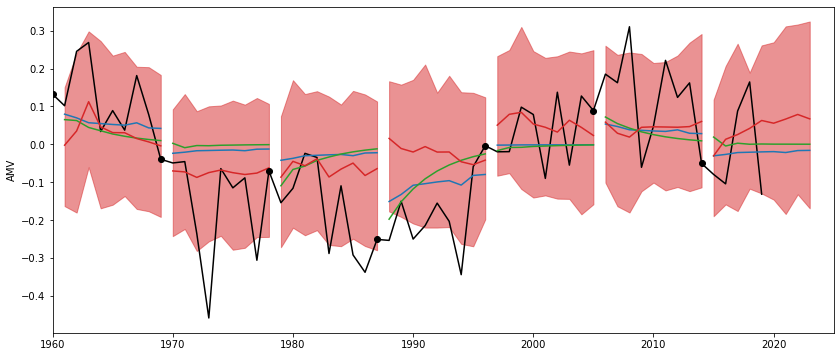

In [214]:
n_steps = 9
var = "AMV"

q = (0.05, 0.95)

fig = plt.figure(figsize=(14, 6))
ax = fig.subplots(1, 1, sharex=True)

reanalysis_plot = reanalysis[var]#.assign_coords({"time": reanalysis.time.dt.year})

ax.plot(reanalysis_plot.time, reanalysis[var], color="k")
for init in hindcast.init.values[:: n_steps]:
    ax.plot(
        init,
        reanalysis_plot.sel(time=init),
        marker="o",
        markersize=6,
        color="k",
    )

    olr_prediction_plot = olr_prediction.sel(init=init).squeeze()

    ax.plot(olr_prediction_plot.lead + init, olr_prediction_plot, color="C0")
    
    ar_prediction_plot = ar_prediction[var].sel(init=init).squeeze()
    ax.plot(ar_prediction_plot.lead + init, ar_prediction_plot, color="C2")

    hindcast_plot = hindcast[var].sel(init=init, lead=slice(n_steps))
    ax.fill_between(
        hindcast_plot.lead + init,
        hindcast_plot.quantile(q[0], "member"),
        hindcast_plot.quantile(q[1], "member"),
        alpha=0.5,
        color="C3",
    )
    ax.plot(hindcast_plot.lead + init, hindcast_plot.mean("member"), color="C3")

    ax.set_ylabel(var)

ax.set_xlim(hindcast.init.min(), hindcast.init.max() + 9)

In [220]:
olr_prediction_acf = stats.acf(
    olr_prediction.sel(lead=slice(2, 9)).mean(["lead"]), dim="init", partial=True
)

ar_prediction_acf = stats.acf(
    ar_prediction.sel(lead=slice(2, 9)).mean(["lead"]), dim="init", partial=True
)

hindcast_acf = stats.acf(
    hindcast.sel(lead=slice(1, 8)).mean(["member", "lead"]), dim="init", partial=True
)

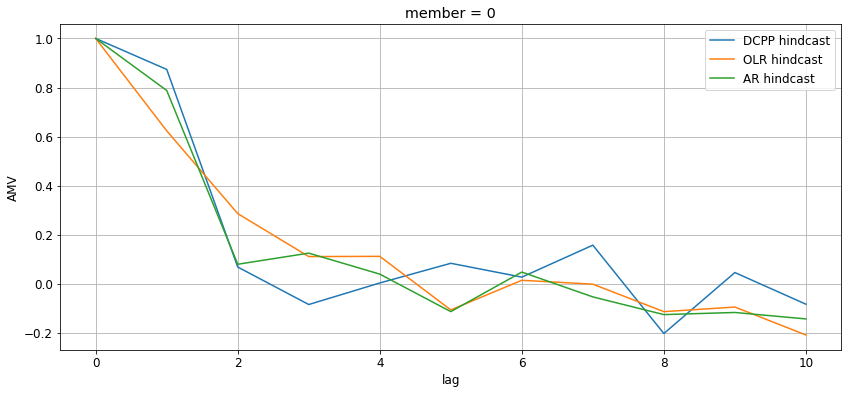

In [227]:
hindcast_acf["AMV"].plot(label="DCPP hindcast")
olr_prediction_acf.plot(label="OLR hindcast")
ar_prediction_acf["AMV"].plot(label="AR hindcast")
plt.legend()

In [ ]:
hindcast

<xarray.Dataset>
Dimensions:  (init: 57, lead: 9, member: 115)
Coordinates:
  * init     (init) int64 1960 1961 1962 1963 1964 ... 2012 2013 2014 2015 2016
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9
  * member   (member) int64 1 2 3 4 5 6 7 8 ... 108 109 110 111 112 113 114 115
    time     (init, lead) object 1962-03-01 00:00:00 ... 2026-03-01 00:00:00
    model    (member) <U18 'CanESM5' 'CanESM5' 'CanESM5' ... 'NorCPM1' 'NorCPM1'
Data variables:
    AMV      (init, member, lead) float64 -0.04975 -0.1255 ... -0.1481 -0.02171
    NAO      (init, member, lead) float64 -12.51 6.162 -0.2441 ... -2.284 -1.628